```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Job Search III: Fitted Value Function Iteration

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!conda install -y quantecon
!pip install interpolation

\ 

| 

/ 

- 

\ 

| 

/ 

- 

\ 

| 

/ 

- 

\ 

| 

/ 

- 

done
Solving environment: | 

/ 

- 

\ 

| 

/ 

- 

\ 

| 

/ 

- 

\ 

| 

/ 

- 

\ 

| 

/ 

- 

\ 

| 

/ 

- 

\ 

| 

/ 

- 

\ 

| 

/ 

- 

done



# All requested packages already installed.



## Overview

In this lecture we again study the {doc}`McCall job search model with separation <mccall_model_with_separation>`, but now with a continuous wage distribution.

While we already considered continuous wage distributions briefly in the
exercises of the {doc}`first job search lecture <mccall_model>`,
the change was relatively trivial in that case.

This is because we were able to reduce the problem to solving for a single
scalar value (the continuation value).

Here, with separation, the change is less trivial, since a continuous wage distribution leads to an uncountably infinite state space.

The infinite state space leads to additional challenges, particularly when it
comes to applying value function iteration (VFI).

These challenges will lead us to modify VFI by adding an interpolation step.

The combination of VFI and this interpolation step is called **fitted value function iteration** (fitted VFI).

Fitted VFI is very common in practice, so we will take some time to work through the details.

We will use the following imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import quantecon as qe
from interpolation import interp
from numpy.random import randn
from numba import njit, prange, float64, int32
from numba.experimental import jitclass

## The Algorithm

The model is the same as the McCall model with job separation we {doc}`studied before <mccall_model_with_separation>`, except that the wage offer distribution is continuous.

We are going to start with the two Bellman equations we obtained for the model with job separation after {ref}`a simplifying transformation <ast_mcm>`.

Modified to accommodate continuous wage draws, they take the following form:

```{math}
:label: bell1mcmc

d = \int \max \left\{ v(w'), \,  u(c) + \beta d \right\} q(w') d w'
```

and

```{math}
:label: bell2mcmc

v(w) = u(w) + \beta
    \left[
        (1-\alpha)v(w) + \alpha d
    \right]
```

The unknowns here are the function $v$ and the scalar $d$.

The difference between these and the pair of Bellman equations we previously worked on are

1. in {eq}`bell1mcmc`, what used to be a sum over a finite number of wage values is an integral over an infinite set.
1. The function $v$ in {eq}`bell2mcmc` is defined over all $w \in \mathbb R_+$.

The function $q$ in {eq}`bell1mcmc` is the density of the wage offer distribution.

Its support is taken as equal to $\mathbb R_+$.

### Value Function Iteration

In theory, we should now proceed as follows:

1. Begin with a guess $v, d$ for the solutions to {eq}`bell1mcmc`--{eq}`bell2mcmc`.
1. Plug $v, d$ into the right hand side of {eq}`bell1mcmc`--{eq}`bell2mcmc` and
   compute the left hand side to obtain updates $v', d'$
1. Unless some stopping condition is satisfied, set $(v, d) = (v', d')$
   and go to step 2.

However, there is a problem we must confront before we implement this procedure:
The iterates of the value function can neither be calculated exactly nor stored on a computer.

To see the issue, consider {eq}`bell2mcmc`.

Even if $v$ is a known function,  the only way to store its update $v'$
is to record its value $v'(w)$ for every $w \in \mathbb R_+$.

Clearly, this is impossible.

### Fitted Value Function Iteration

What we will do instead is use **fitted value function iteration**.

The procedure is as follows:

Let a current guess $v$ be given.

Now we record the value of the function $v'$ at only
finitely many "grid" points $w_1 < w_2 < \cdots < w_I$ and then reconstruct $v'$ from this information when required.

More precisely, the algorithm will be

(fvi_alg)=
1. Begin with an array $\mathbf v$ representing the values of an initial guess of the value function on some grid points $\{w_i\}$.
1. Build a function $v$ on the state space $\mathbb R_+$ by interpolation or approximation, based on $\mathbf v$ and $\{ w_i\}$.
1. Obtain and record the samples of the updated function $v'(w_i)$ on each grid point $w_i$.
1. Unless some stopping condition is satisfied, take this as the new array and go to step 1.

How should we go about step 2?

This is a problem of function approximation, and there are many ways to approach it.

What's important here is that the function approximation scheme must not only
produce a good approximation to each $v$, but also that it combines well with the broader iteration algorithm described above.

One good choice from both respects is continuous piecewise linear interpolation.

This method

1. combines well with value function iteration (see., e.g.,
   {cite}`gordon1995stable` or {cite}`stachurski2008continuous`) and
1. preserves useful shape properties such as monotonicity and concavity/convexity.

Linear interpolation will be implemented using a JIT-aware Python interpolation library called [interpolation.py](https://github.com/EconForge/interpolation.py).

The next figure illustrates piecewise linear interpolation of an arbitrary
function on grid points $0, 0.2, 0.4, 0.6, 0.8, 1$.

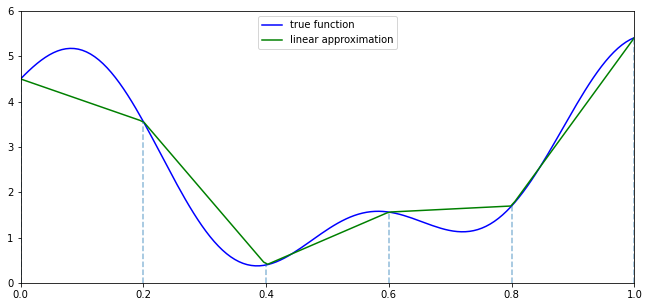

In [3]:
def f(x):
    y1 = 2 * np.cos(6 * x) + np.sin(14 * x)
    return y1 + 2.5

c_grid = np.linspace(0, 1, 6)
f_grid = np.linspace(0, 1, 150)

def Af(x):
    return interp(c_grid, f(c_grid), x)

fig, ax = plt.subplots()

ax.plot(f_grid, f(f_grid), 'b-', label='true function')
ax.plot(f_grid, Af(f_grid), 'g-', label='linear approximation')
ax.vlines(c_grid, c_grid * 0, f(c_grid), linestyle='dashed', alpha=0.5)

ax.legend(loc="upper center")

ax.set(xlim=(0, 1), ylim=(0, 6))
plt.show()

## Implementation

The first step is to build a jitted class for the McCall model with separation and
a continuous wage offer distribution.

We will take the utility function to be the log function for this application, with $u(c) = \ln c$.

We will adopt the lognormal distribution for wages, with $w = \exp(\mu + \sigma z)$
when $z$ is standard normal and $\mu, \sigma$ are parameters.

In [4]:
@njit
def lognormal_draws(n=1000, μ=2.5, σ=0.5, seed=1234):
    np.random.seed(seed)
    z = np.random.randn(n)
    w_draws = np.exp(μ + σ * z)
    return w_draws

Here's our class.

In [5]:
mccall_data_continuous = [
    ('c', float64),          # unemployment compensation
    ('α', float64),          # job separation rate
    ('β', float64),          # discount factor
    ('σ', float64),          # scale parameter in lognormal distribution
    ('μ', float64),          # location parameter in lognormal distribution
    ('w_grid', float64[:]),  # grid of points for fitted VFI
    ('w_draws', float64[:])  # draws of wages for Monte Carlo
]

@jitclass(mccall_data_continuous)
class McCallModelContinuous:

    def __init__(self,
                 c=1,
                 α=0.1,
                 β=0.96,
                 grid_min=1e-10,
                 grid_max=5,
                 grid_size=100,
                 w_draws=lognormal_draws()):

        self.c, self.α, self.β = c, α, β

        self.w_grid = np.linspace(grid_min, grid_max, grid_size)
        self.w_draws = w_draws

    def update(self, v, d):

        # Simplify names
        c, α, β, σ, μ = self.c, self.α, self.β, self.σ, self.μ
        w = self.w_grid
        u = lambda x: np.log(x)

        # Interpolate array represented value function
        vf = lambda x: interp(w, v, x)

        # Update d using Monte Carlo to evaluate integral
        d_new = np.mean(np.maximum(vf(self.w_draws), u(c) + β * d))

        # Update v
        v_new = u(w) + β * ((1 - α) * v + α * d)

        return v_new, d_new

We then return the current iterate as an approximate solution.

In [6]:
@njit
def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    * mcm is an instance of McCallModel
    """

    v = np.ones_like(mcm.w_grid)    # Initial guess of v
    d = 1                           # Initial guess of d
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_new, d_new = mcm.update(v, d)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(d_new - d)
        error = max(error_1, error_2)
        v = v_new
        d = d_new
        i += 1

    return v, d

Here's a function `compute_reservation_wage` that takes an instance of `McCallModelContinuous`
and returns the associated reservation wage.

If $v(w) < h$ for all $w$, then the function returns np.inf

In [7]:
@njit
def compute_reservation_wage(mcm):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v(w) >= h.

    If no such w exists, then w_bar is set to np.inf.
    """
    u = lambda x: np.log(x)

    v, d = solve_model(mcm)
    h = u(mcm.c) + mcm.β * d

    w_bar = np.inf
    for i, wage in enumerate(mcm.w_grid):
        if v[i] > h:
            w_bar = wage
            break

    return w_bar

The exercises ask you to explore the solution and how it changes with parameters.

## Exercises

```{exercise}
:label: mfv_ex1

Use the code above to explore what happens to the reservation wage when the wage parameter $\mu$
changes.

Use the default parameters and $\mu$ in `mu_vals = np.linspace(0.0, 2.0, 15)`.

Is the impact on the reservation wage as you expected?
```


```{exercise}
:label: mfv_ex2

Let us now consider how the agent responds to an increase in volatility.

To try to understand this, compute the reservation wage when the wage offer
distribution is uniform on $(m - s, m + s)$ and $s$ varies.

The idea here is that we are holding the mean constant and spreading the
support.

(This is a form of *mean-preserving spread*.)

Use `s_vals = np.linspace(1.0, 2.0, 15)` and `m = 2.0`.

State how you expect the reservation wage to vary with $s$.

Now compute it.  Is this as you expected?
```

## Solutions

```{solution-start} mfv_ex1
```

Here is one solution.

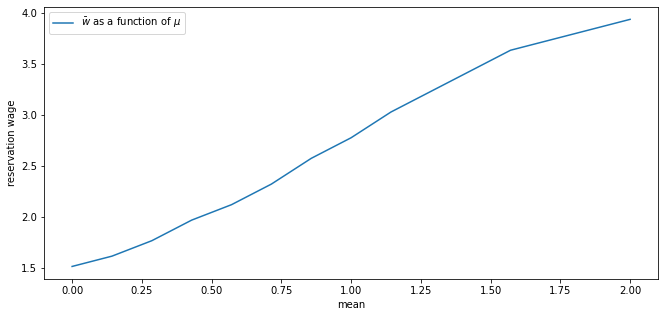

In [8]:
mcm = McCallModelContinuous()
mu_vals = np.linspace(0.0, 2.0, 15)
w_bar_vals = np.empty_like(mu_vals)

fig, ax = plt.subplots()

for i, m in enumerate(mu_vals):
    mcm.w_draws = lognormal_draws(μ=m)
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='mean', ylabel='reservation wage')
ax.plot(mu_vals, w_bar_vals, label=r'$\bar w$ as a function of $\mu$')
ax.legend()

plt.show()

Not surprisingly, the agent is more inclined to wait when the distribution of
offers shifts to the right.

```{solution-end}
```


```{solution-start} mfv_ex2
```

Here is one solution.

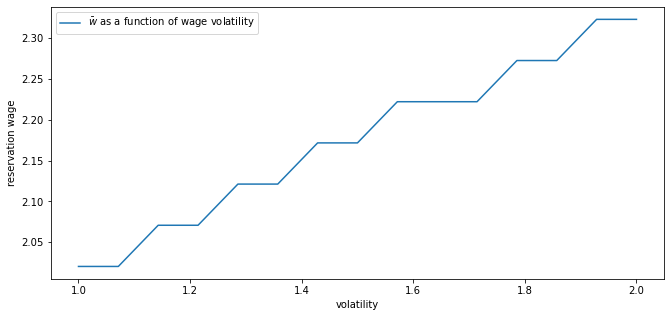

In [9]:
mcm = McCallModelContinuous()
s_vals = np.linspace(1.0, 2.0, 15)
m = 2.0
w_bar_vals = np.empty_like(s_vals)

fig, ax = plt.subplots()

for i, s in enumerate(s_vals):
    a, b = m - s, m + s
    mcm.w_draws = np.random.uniform(low=a, high=b, size=10_000)
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='volatility', ylabel='reservation wage')
ax.plot(s_vals, w_bar_vals, label=r'$\bar w$ as a function of wage volatility')
ax.legend()

plt.show()

The reservation wage increases with volatility.

One might think that higher volatility would make the agent more inclined to
take a given offer, since doing so represents certainty and waiting represents
risk.

But job search is like holding an option: the worker is only exposed to upside risk (since, in a free market, no one can force them to take a bad offer).

More volatility means higher upside potential, which encourages the agent to wait.

```{solution-end}
```